# 0) Modules & Functions

In [7]:
import pandas as pd 
from tqdm import tqdm
import os
import re
from rdkit import Chem
from rdkit.Chem import inchi
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from scipy.stats import wasserstein_distance

# Compute InChIKey from SMILES
def smiles_to_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        return inchi.MolToInchiKey(mol)
    except:
        return None
    
def subscript(text):
    return f"$_{{{text}}}$"

def _replace_subscript(name):
    name = name.replace('Caco-2-2', 'Caco-2')
    name = name.replace('(Rat)', '(RAT)')
    name = name.replace('(Human,', '(HUMAN,')
    name = name.replace('(Rat,', '(RAT,')
    name = name.replace('(po, Rat,', '(po, RAT,')
    name = name.replace('(Mouse,', '(MOUSE,')
    name = name.replace('(Mouse)', '(MOUSE)')
    name = name.replace('(Rat)', '(RAT)')
    name = name.replace('(Dog,', '(DOG,')
    name = name.replace('Prolif (Cell)', 'Cell-prolif')
    name = name.replace('Half Life Microsome', 'logHalf-life$_{microsomal}$')
    name = name.replace('Half Life Plasma', 'logHalf-life$_{plasma}$')
    name = name.replace('Clearance Microsomal', 'logClearance$_{microsomal}$')
    name = name.replace('Clearance Total', 'logClearance$_{total}$')
    name = name.replace('Clearance Total', 'logClearance$_{total}$')
    name = name.replace('Clearance Renal', 'logClearance$_{renal}$')
    name = name.replace(', Cell)', ')')
    name = name.replace('Growth Tumor', 'Tumor-growth')
    name = name.replace('logClearance$_{total}$ iv (RAT,', 'logClearance$_{total}$ (iv, RAT,')
    name = name.replace('Stability Microsomal', 'Stability$_{microsomal}$')
    name = name.replace('pVD', 'logVD')
    return name

def clean_endpoint_name(name):
    name = name.replace('.csv', '')

    # Replace raw units with readable forms (keep lowercase)
    name = name.replace('pmL%min%kg', 'µL·min⁻¹·kg⁻¹')
    name = name.replace('pmg%kg', 'mg·kg⁻¹')
    name = name.replace('pHours', 'h')
    name = name.replace('pL%kg', 'L·kg⁻¹')
    name = name.replace('mol%kg', 'mol·kg⁻¹')

    # Remove prefixes
    name = re.sub(r'^(PUBLIC|BindingDB)___', '', name)

    # Replace separators and clean up
    name = name.replace('-', ' ').replace('_', ' ').replace('Public', '')
    name = re.sub(r'\s+', ' ', name).strip()

    # Remove "Biochemical"
    name = re.sub(r'\bBiochemical\b', '', name)

    # Fix substrings for cell types, models
    name = re.sub(r'\bCaco2\b', 'Caco-2', name)
    name = re.sub(r'\bCaco\b', 'Caco-2', name)
    name = re.sub(r'MDCK LE\b', 'MDCK-LE', name)
    name = re.sub(r'MDCK MDR1\b', 'MDCK-MDR1', name)
    name = re.sub(r'MCDK MDR1\b', 'MDCK-MDR1', name)

    # Apply LaTeX-style subscripts
    name = re.sub(r'\bp(IC|GI|LD|TD)50\b', lambda m: f"p{m.group(1)}{subscript('50')}", name)
    name = re.sub(r'\bpVDss\b', lambda _: f"pVD{subscript('ss')}", name)
    name = re.sub(r'\bpKi\b', lambda _: f"pK{subscript('i')}", name)
    name = re.sub(r'\bpKd\b', lambda _: f"pK{subscript('d')}", name)

    # logX formatting with special subscripts
    name = re.sub(r'\bLogD74\b', lambda _: f"logD{subscript('7-4')}", name)
    name = re.sub(r'\bLogPapp\b', lambda _: f"logP{subscript('app')}", name)
    name = re.sub(r'\bLogPow\b', lambda _: f"logP{subscript('ow')}", name)
    name = re.sub(r'\bLogS Water\b', lambda _: f"logS{subscript('water')}", name)
    name = re.sub(r'\bLogS Apparent\b', lambda _: f"logS{subscript('buffer')}", name)
    name = re.sub(r'\bLog([A-Z])', r'log\1', name)


    # Tokenize and collect metadata
    tokens = name.split()
    main = []
    meta = []

    # Reference species, sources, tissues, etc.
    meta_whitelist = {
        'MOUSE', 'RAT', 'HUMAN', 'DOG', 'HAMSTER', 'CELL',
        'PO', 'CAVPO', 'TETCF', 'CANEN', 'MYCTU', 'SARS', 'SARS2',
        'MDCK-MDR1', 'MDCK-LE', 'Caco-2', 'PAMPA', 'BOVIN', 'HV1BR', 
        'HV1H2', 'PIG', 'BACAN', 'TRYCR', 'CANAL', 'ECOLX',  'ECOLI', 
        'MESAU', 'HELPY', 'HCMVA', 'CHICK', "HCMVA", 'RICCO', 'MACFA', 
        'PLAF7','SPIOL', 'HV1N5', 'HV1H2', 'HV1BR', 'HV1B1', 'HCVJ4', 
        'HCVCO', 'HCVBK', 'HCV77', 'SHEEP', 'I34A1', 'CARPA','MELGA', 
        'INBLE', 'I77AB', 'I75A5', 'I34A1', 'I33A0', 'CLOPF', 'HELPJ', 
        'YEAST', 'PHOPY', 'PSEAE', 'HHV1S', "PORG3", 'MYCSM', 'STAAU',
        'HBVD3','ENTFA','HV1H2','PNECA', 'TOXGO', 'PLAFK', 'LEIMA', 'STAAU',
        'STAAM', 'TRYCR', 'STAAE', 'RABIT', 'AGABI', 'BACFG', 'BACSU', 'CLOBO', 'ELEEL', 'ENTCL', 'HORSE', 'KLEPN', 'LACCA', 'SERMA', 'STAAR'
    }

    unit_patterns = ['µL·min⁻¹·kg⁻¹', 'mg·kg⁻¹', 'L·kg⁻¹', 'mol·kg⁻¹', 'h']

    for token in tokens:
        token_upper = token.upper()
        if token in unit_patterns or token in meta_whitelist or token_upper in meta_whitelist:
            meta.append(token)
        elif token_upper in meta_whitelist:
            meta.append(token_upper)
        elif token.isupper() and len(token) <= 6:  # likely gene or protein name
            main.append(token)
        else:
            main.append(token)

    # Remove duplicates from meta, preserve order
    seen = set()
    meta_clean = []
    for m in meta:
        if m not in seen:
            seen.add(m)
            meta_clean.append(m)


    if meta_clean:
        return _replace_subscript(f"{' '.join(main)} ({', '.join(meta_clean)})")
    else:
        return _replace_subscript(' '.join(main))
    

import pandas as pd
import numpy as np

def random_split_with_distribution(df):
    df = df.copy()
    
    # Assign random sets
    sets = ['A', 'B', 'C', 'D', 'E','F','G','H','I','J']
    df['Set'] = np.random.choice(sets, size=len(df))

    # Print distribution
    set_counts = df['Set'].value_counts(normalize=True) * 100
    print("Percentage per set:\n", set_counts)

    return df

# 1) Data loading

In [8]:
df_full = pd.read_parquet('../data/exp/oneADMET.parquet')

# 2) Filter by dataset size

In [9]:
# Assuming df_full is your DataFrame
min_non_nan = 50
max_non_nan = 10000

valid_cols = [

    col for col in tqdm(df_full.columns)
    if min_non_nan <= df_full[col].notna().sum() <= max_non_nan
]

# If you want to exclude 'SMILES' and 'Set' columns from the check:
valid_cols = [
    col for col in tqdm(df_full.columns)
    if col not in ['SMILES', 'Set'] and min_non_nan <= df_full[col].notna().sum() <= max_non_nan
]

to_remove = [
    "PUBLIC___pIC50_CYP1A2_HUMAN_Biochemical_Public.csv",
    "PUBLIC___pIC50_CYP2C19_HUMAN_Biochemical_Public.csv",
    "PUBLIC___pIC50_CYP2C9_HUMAN_Biochemical_Public.csv",
    "PUBLIC___pIC50_CYP2D6_HUMAN_Biochemical_Public.csv",
    "PUBLIC___pIC50_CYP3A4_HUMAN_Biochemical_Public.csv",
    "pLD50_Unknown_Public.csv",
    "PUBLIC___LogHydrationFreeEnergy_Public.csv",
    "PPB_Human_Public.csv",
    "BindingDB___pIC50_CYP19A_HUMAN_Biochemical.csv",
    "BindingDB___pIC50_CYP1A1_HUMAN_Biochemical.csv",
    "BindingDB___pIC50_CYP1A2_HUMAN_Biochemical.csv",
    "BindingDB___pIC50_CYP1B1_HUMAN_Biochemical.csv",
    "BindingDB___pIC50_CYP2B6_HUMAN_Biochemical.csv",
    "BindingDB___pIC50_CYP4F2_HUMAN_Biochemical.csv"
]

filtered_cols = [
    col for col in tqdm(df_full.columns)
    if col not in ['SMILES', 'Set']
    and min_non_nan <= df_full[col].notna().sum() <= max_non_nan
    and col not in to_remove
]

# Keep only SMILES, Set, and the filtered columns
df_filtered = df_full[["SMILES"] + filtered_cols]

# Drop rows where all values in filtered_cols are NaN
df_filtered = df_filtered.dropna(subset=filtered_cols, how='all').sample(frac=1, random_state=42).reset_index(drop=True)


100%|██████████| 1535/1535 [00:00<00:00, 3072.37it/s]


# 2.5) Assign set

In [10]:
df_split = random_split_with_distribution(df_filtered)

Percentage per set:
 Set
I    10.047320
E    10.041555
D    10.026997
J    10.018493
H    10.014169
G    10.006385
A     9.969198
C     9.961991
B     9.958820
F     9.955073
Name: proportion, dtype: float64


# 3) Keep large enough test

In [11]:
set_out = []
for col in tqdm(filtered_cols):
    # Keep only SMILES, Set, and current column
    df_unique = df_split[["SMILES", "Set", col]].dropna()

    # Calculate % of each set
    set_counts = df_unique["Set"].value_counts(normalize=True)

    # Print if any set has more than 10%
    for set_name, frac in set_counts.items():
        if frac < 0.05:
            set_out.append(col)
            print(f" {col} {frac:.2%} in {set_name} set")


  3%|▎         | 42/1343 [00:02<01:27, 14.79it/s]

 BindingDB___pIC50_5NTD_RAT_Biochemical.csv 4.29% in F set
 BindingDB___pIC50_AA1R_BOVIN_Biochemical.csv 4.00% in H set


  5%|▍         | 66/1343 [00:04<01:26, 14.78it/s]

 BindingDB___pIC50_ACH10_HUMAN_Biochemical.csv 4.35% in H set


  6%|▌         | 80/1343 [00:05<01:25, 14.69it/s]

 BindingDB___pIC50_ACMSD_HUMAN_Biochemical.csv 4.17% in G set


  7%|▋         | 88/1343 [00:05<01:25, 14.74it/s]

 BindingDB___pIC50_ADA2C_HUMAN_Biochemical.csv 3.51% in F set
 BindingDB___pIC50_ADCY1_HUMAN_Biochemical.csv 4.96% in I set


  7%|▋         | 92/1343 [00:06<01:25, 14.72it/s]

 BindingDB___pIC50_ADRB3_HUMAN_Biochemical.csv 4.00% in J set
 BindingDB___pIC50_ADRB3_HUMAN_Biochemical.csv 2.00% in C set


  7%|▋         | 98/1343 [00:06<01:24, 14.73it/s]

 BindingDB___pIC50_AK1BA_HUMAN_Biochemical.csv 4.13% in I set


  8%|▊         | 102/1343 [00:06<01:24, 14.69it/s]

 BindingDB___pIC50_AL1A3_HUMAN_Biochemical.csv 4.30% in C set


  8%|▊         | 106/1343 [00:07<01:24, 14.72it/s]

 BindingDB___pIC50_ALDR_PIG_Biochemical.csv 4.46% in G set
 BindingDB___pIC50_ALDR_PIG_Biochemical.csv 3.57% in I set


  9%|▉         | 118/1343 [00:08<01:23, 14.69it/s]

 BindingDB___pIC50_ANM3_HUMAN_Biochemical.csv 3.80% in E set


 10%|▉         | 132/1343 [00:08<01:22, 14.73it/s]

 BindingDB___pIC50_ARBK1_BOVIN_Biochemical.csv 4.23% in A set


 11%|█         | 150/1343 [00:10<01:21, 14.69it/s]

 BindingDB___pIC50_BAZ2A_HUMAN_Biochemical.csv 3.80% in E set


 12%|█▏        | 158/1343 [00:10<01:20, 14.73it/s]

 BindingDB___pIC50_BLAB_BACFG_Biochemical.csv 4.76% in H set


 12%|█▏        | 162/1343 [00:11<01:20, 14.68it/s]

 BindingDB___pIC50_BLM_HUMAN_Biochemical.csv 3.64% in B set
 BindingDB___pIC50_BLM_HUMAN_Biochemical.csv 3.64% in I set


 14%|█▎        | 184/1343 [00:12<01:18, 14.78it/s]

 BindingDB___pIC50_CAH12_HUMAN_Biochemical.csv 3.85% in G set


 15%|█▌        | 204/1343 [00:13<01:16, 14.80it/s]

 BindingDB___pIC50_CCNE1_HUMAN_Biochemical.csv 3.77% in C set


 16%|█▋        | 220/1343 [00:14<01:16, 14.77it/s]

 BindingDB___pIC50_CETP_RABIT_Biochemical.csv 4.72% in A set


 17%|█▋        | 224/1343 [00:15<01:15, 14.78it/s]

 BindingDB___pIC50_CGL_HUMAN_Biochemical.csv 3.57% in C set


 18%|█▊        | 240/1343 [00:16<01:15, 14.63it/s]

 BindingDB___pIC50_CP2B1_RAT_Biochemical.csv 3.70% in I set


 18%|█▊        | 244/1343 [00:16<01:14, 14.66it/s]

 BindingDB___pIC50_CRCM1_HUMAN_Biochemical.csv 4.50% in H set


 19%|█▉        | 252/1343 [00:17<01:14, 14.74it/s]

 BindingDB___pIC50_CTNB1_HUMAN_Biochemical.csv 4.94% in D set


 20%|█▉        | 264/1343 [00:17<01:12, 14.79it/s]

 BindingDB___pIC50_DEF_STAAM_Biochemical.csv 4.41% in E set
 BindingDB___pIC50_DEFM_HUMAN_Biochemical.csv 3.90% in A set


 20%|██        | 272/1343 [00:18<01:12, 14.77it/s]

 BindingDB___pIC50_DHI1_RAT_Biochemical.csv 3.53% in C set
 BindingDB___pIC50_DHSO_HUMAN_Biochemical.csv 4.11% in D set
 BindingDB___pIC50_DNLI1_HUMAN_Biochemical.csv 3.85% in D set


 21%|██▏       | 286/1343 [00:19<01:11, 14.78it/s]

 BindingDB___pIC50_DRTS_LEIMA_Biochemical.csv 4.84% in F set


 22%|██▏       | 290/1343 [00:19<01:11, 14.78it/s]

 BindingDB___pIC50_DUS1_HUMAN_Biochemical.csv 2.53% in A set
 BindingDB___pIC50_DYR_BOVIN_Biochemical.csv 4.86% in F set


 23%|██▎       | 314/1343 [00:21<01:09, 14.76it/s]

 BindingDB___pIC50_EGLN3_HUMAN_Biochemical.csv 4.51% in G set


 24%|██▍       | 324/1343 [00:22<01:09, 14.71it/s]

 BindingDB___pIC50_ERG1_HUMAN_Biochemical.csv 3.17% in C set
 BindingDB___pIC50_ERG1_HUMAN_Biochemical.csv 3.17% in B set


 25%|██▌       | 342/1343 [00:23<01:07, 14.80it/s]

 BindingDB___pIC50_FABH_ENTFA_Biochemical.csv 4.00% in H set
 BindingDB___pIC50_FABI_ECOLI_Biochemical.csv 3.03% in J set


 26%|██▌       | 352/1343 [00:23<01:07, 14.74it/s]

 BindingDB___pIC50_FFAR2_HUMAN_Biochemical.csv 2.26% in I set


 27%|██▋       | 362/1343 [00:24<01:06, 14.79it/s]

 BindingDB___pIC50_FNTB_YEAST_Biochemical.csv 3.95% in F set


 28%|██▊       | 370/1343 [00:25<01:05, 14.80it/s]

 BindingDB___pIC50_GBA2_HUMAN_Biochemical.csv 4.55% in B set
 BindingDB___pIC50_GBRA1_HUMAN_Biochemical.csv 4.35% in I set
 BindingDB___pIC50_GCN5_YEAST_Biochemical.csv 4.08% in D set


 28%|██▊       | 376/1343 [00:25<01:05, 14.74it/s]

 BindingDB___pIC50_GIPR_HUMAN_Biochemical.csv 2.88% in A set


 29%|██▊       | 386/1343 [00:26<01:04, 14.72it/s]

 BindingDB___pIC50_GRIA1_RAT_Biochemical.csv 4.76% in D set
 BindingDB___pIC50_GRIA1_RAT_Biochemical.csv 1.19% in I set


 30%|██▉       | 398/1343 [00:27<01:04, 14.73it/s]

 BindingDB___pIC50_GSTM2_HUMAN_Biochemical.csv 3.57% in I set


 31%|███       | 416/1343 [00:28<01:03, 14.71it/s]

 BindingDB___pIC50_HDAC9_HUMAN_Biochemical.csv 4.86% in A set
 BindingDB___pIC50_HEPS_HUMAN_Biochemical.csv 4.11% in F set


 31%|███▏      | 422/1343 [00:28<01:02, 14.68it/s]

 BindingDB___pIC50_HPPD_PIG_Biochemical.csv 3.51% in F set


 33%|███▎      | 440/1343 [00:29<01:01, 14.76it/s]

 BindingDB___pIC50_IL8_HUMAN_Biochemical.csv 3.85% in E set


 34%|███▎      | 450/1343 [00:30<01:00, 14.72it/s]

 BindingDB___pIC50_ITB8_HUMAN_Biochemical.csv 4.88% in G set


 35%|███▍      | 466/1343 [00:31<00:59, 14.79it/s]

 BindingDB___pIC50_KCNJ5_HUMAN_Biochemical.csv 4.76% in A set
 BindingDB___pIC50_KCNJ5_HUMAN_Biochemical.csv 4.76% in J set
 BindingDB___pIC50_KCNT1_HUMAN_Biochemical.csv 3.28% in D set


 35%|███▌      | 474/1343 [00:32<00:58, 14.78it/s]

 BindingDB___pIC50_KDM4D_HUMAN_Biochemical.csv 4.40% in G set


 37%|███▋      | 492/1343 [00:33<00:57, 14.78it/s]

 BindingDB___pIC50_KS6A1_HUMAN_Biochemical.csv 3.64% in F set
 BindingDB___pIC50_KS6A5_HUMAN_Biochemical.csv 4.55% in F set


 37%|███▋      | 500/1343 [00:33<00:57, 14.72it/s]

 BindingDB___pIC50_LCK_MOUSE_Biochemical.csv 1.45% in G set


 38%|███▊      | 504/1343 [00:34<00:56, 14.77it/s]

 BindingDB___pIC50_LIMK2_HUMAN_Biochemical.csv 4.00% in H set


 38%|███▊      | 508/1343 [00:34<00:56, 14.74it/s]

 BindingDB___pIC50_LMBL3_HUMAN_Biochemical.csv 4.76% in H set


 38%|███▊      | 514/1343 [00:34<00:56, 14.78it/s]

 BindingDB___pIC50_LPAR3_HUMAN_Biochemical.csv 3.75% in E set


 39%|███▉      | 530/1343 [00:35<00:54, 14.81it/s]

 BindingDB___pIC50_MAL32_YEAST_Biochemical.csv 3.23% in B set


 40%|███▉      | 536/1343 [00:36<00:54, 14.78it/s]

 BindingDB___pIC50_MBD2_HUMAN_Biochemical.csv 3.77% in D set
 BindingDB___pIC50_MBD2_HUMAN_Biochemical.csv 1.89% in F set
 BindingDB___pIC50_MBD2_HUMAN_Biochemical.csv 1.89% in G set


 41%|████      | 544/1343 [00:36<00:54, 14.73it/s]

 BindingDB___pIC50_MDR1B_MOUSE_Biochemical.csv 2.86% in F set


 41%|████▏     | 554/1343 [00:37<00:53, 14.69it/s]

 BindingDB___pIC50_MGLL_RAT_Biochemical.csv 4.88% in A set
 BindingDB___pIC50_MGLL_RAT_Biochemical.csv 4.07% in I set


 42%|████▏     | 562/1343 [00:38<00:53, 14.60it/s]

 BindingDB___pIC50_MK13_HUMAN_Biochemical.csv 4.88% in H set


 43%|████▎     | 582/1343 [00:39<00:52, 14.44it/s]

 BindingDB___pIC50_MTR1B_HUMAN_Biochemical.csv 4.48% in F set
 BindingDB___pIC50_MTR1B_HUMAN_Biochemical.csv 2.99% in C set
 BindingDB___pIC50_MURA_ECOLI_Biochemical.csv 4.29% in G set


 44%|████▎     | 586/1343 [00:39<00:52, 14.38it/s]

 BindingDB___pIC50_MYB_CHICK_Biochemical.csv 1.75% in G set
 BindingDB___pIC50_MYLK_CHICK_Biochemical.csv 4.04% in J set


 44%|████▍     | 590/1343 [00:40<00:52, 14.32it/s]

 BindingDB___pIC50_NDUV1_BOVIN_Biochemical.csv 3.45% in B set
 BindingDB___pIC50_NEUR4_HUMAN_Biochemical.csv 4.62% in A set
 BindingDB___pIC50_NEUR4_HUMAN_Biochemical.csv 3.08% in G set
 BindingDB___pIC50_NF2L2_HUMAN_Biochemical.csv 4.52% in J set


 45%|████▍     | 598/1343 [00:40<00:51, 14.40it/s]

 BindingDB___pIC50_NLRP3_MOUSE_Biochemical.csv 4.78% in G set


 45%|████▌     | 610/1343 [00:41<00:50, 14.53it/s]

 BindingDB___pIC50_NOTC1_HUMAN_Biochemical.csv 3.81% in C set
 BindingDB___pIC50_NPSR1_HUMAN_Biochemical.csv 3.57% in C set


 46%|████▌     | 618/1343 [00:42<00:49, 14.54it/s]

 BindingDB___pIC50_NQO1_HUMAN_Biochemical.csv 4.76% in G set


 46%|████▌     | 620/1343 [00:42<00:50, 14.43it/s]

 BindingDB___pIC50_NR1I3_HUMAN_Biochemical.csv 3.85% in I set
 BindingDB___pIC50_NR1I3_HUMAN_Biochemical.csv 1.92% in A set


 47%|████▋     | 630/1343 [00:42<00:50, 14.16it/s]

 BindingDB___pIC50_NUAK1_HUMAN_Biochemical.csv 4.76% in H set
 BindingDB___pIC50_NUAK1_HUMAN_Biochemical.csv 4.76% in E set
 BindingDB___pIC50_NUAK1_HUMAN_Biochemical.csv 4.76% in J set


 48%|████▊     | 648/1343 [00:44<00:48, 14.26it/s]

 BindingDB___pIC50_P2RY1_MELGA_Biochemical.csv 4.69% in I set


 49%|████▊     | 652/1343 [00:44<00:48, 14.36it/s]

 BindingDB___pIC50_P4HTM_HUMAN_Biochemical.csv 4.88% in C set
 BindingDB___pIC50_P4HTM_HUMAN_Biochemical.csv 4.88% in B set
 BindingDB___pIC50_P4HTM_HUMAN_Biochemical.csv 4.88% in I set


 49%|████▉     | 664/1343 [00:45<00:46, 14.52it/s]

 BindingDB___pIC50_PAPA1_CARPA_Biochemical.csv 4.48% in I set


 50%|████▉     | 670/1343 [00:45<00:45, 14.66it/s]

 BindingDB___pIC50_PB1_HUMAN_Biochemical.csv 1.64% in I set
 BindingDB___pIC50_PD2R_MOUSE_Biochemical.csv 2.90% in B set


 52%|█████▏    | 696/1343 [00:47<00:44, 14.57it/s]

 BindingDB___pIC50_PDK4_HUMAN_Biochemical.csv 4.05% in E set
 BindingDB___pIC50_PDK4_RAT_Biochemical.csv 3.51% in G set


 53%|█████▎    | 710/1343 [00:48<00:43, 14.66it/s]

 BindingDB___pIC50_PGH2_RAT_Biochemical.csv 1.92% in F set
 BindingDB___pIC50_PGTB1_HUMAN_Biochemical.csv 4.00% in D set


 54%|█████▎    | 720/1343 [00:49<00:42, 14.60it/s]

 BindingDB___pIC50_PK3CA_MOUSE_Biochemical.csv 4.76% in B set
 BindingDB___pIC50_PK3CB_RAT_Biochemical.csv 3.70% in H set


 55%|█████▌    | 740/1343 [00:50<00:41, 14.49it/s]

 BindingDB___pIC50_POLG_HCVJ4_Biochemical.csv 3.45% in D set
 BindingDB___pIC50_POLG_HCVJ4_Biochemical.csv 1.72% in C set


 55%|█████▌    | 742/1343 [00:50<00:41, 14.39it/s]

 BindingDB___pIC50_PPBI_HUMAN_Biochemical.csv 4.49% in J set


 56%|█████▌    | 746/1343 [00:50<00:41, 14.43it/s]

 BindingDB___pIC50_PPCE_PIG_Biochemical.csv 4.90% in D set


 56%|█████▌    | 754/1343 [00:51<00:41, 14.16it/s]

 BindingDB___pIC50_PSBA_SPIOL_Biochemical.csv 4.76% in F set
 BindingDB___pIC50_PSBA_SPIOL_Biochemical.csv 3.17% in H set


 57%|█████▋    | 764/1343 [00:52<00:39, 14.66it/s]

 BindingDB___pIC50_PTPRC_HUMAN_Biochemical.csv 4.35% in E set
 BindingDB___pIC50_PTPRF_HUMAN_Biochemical.csv 4.94% in E set


 58%|█████▊    | 774/1343 [00:52<00:38, 14.69it/s]

 BindingDB___pIC50_RENI_MACFA_Biochemical.csv 4.49% in D set
 BindingDB___pIC50_RICI_RICCO_Biochemical.csv 4.41% in B set
 BindingDB___pIC50_RICI_RICCO_Biochemical.csv 2.94% in A set


 59%|█████▊    | 786/1343 [00:53<00:38, 14.47it/s]

 BindingDB___pIC50_RPOB_ECOLI_Biochemical.csv 3.70% in G set


 60%|██████    | 808/1343 [00:55<00:36, 14.49it/s]

 BindingDB___pIC50_SC6A5_HUMAN_Biochemical.csv 4.96% in H set
 BindingDB___pIC50_SC6A9_RAT_Biochemical.csv 3.60% in G set


 61%|██████    | 818/1343 [00:55<00:36, 14.35it/s]

 BindingDB___pIC50_SCN3A_HUMAN_Biochemical.csv 4.69% in E set
 BindingDB___pIC50_SCN3A_HUMAN_Biochemical.csv 4.69% in A set


 64%|██████▍   | 858/1343 [00:58<00:34, 14.22it/s]

 BindingDB___pIC50_STK3_HUMAN_Biochemical.csv 3.45% in B set


 66%|██████▌   | 880/1343 [01:00<00:31, 14.60it/s]

 BindingDB___pIC50_TNI3K_HUMAN_Biochemical.csv 4.06% in F set


 66%|██████▌   | 888/1343 [01:00<00:31, 14.50it/s]

 BindingDB___pIC50_TRM3_HCMVA_Biochemical.csv 1.67% in E set
 BindingDB___pIC50_TRPC3_HUMAN_Biochemical.csv 3.45% in E set


 67%|██████▋   | 904/1343 [01:01<00:30, 14.35it/s]

 BindingDB___pIC50_TYPH_HUMAN_Biochemical.csv 4.00% in B set


 68%|██████▊   | 912/1343 [01:02<00:29, 14.45it/s]

 BindingDB___pIC50_UT2_RAT_Biochemical.csv 3.77% in G set


 69%|██████▊   | 920/1343 [01:02<00:29, 14.34it/s]

 BindingDB___pIC50_VGFR2_MOUSE_Biochemical.csv 4.55% in I set


 69%|██████▉   | 924/1343 [01:03<00:29, 14.41it/s]

 BindingDB___pIC50_WDR5_HUMAN_Biochemical.csv 4.26% in G set


 70%|██████▉   | 934/1343 [01:03<00:28, 14.60it/s]

 BindingDB___pKd_ACES_HUMAN_Biochemical.csv 3.80% in G set
 BindingDB___pKd_ACM1_HUMAN_Biochemical.csv 3.77% in H set
 BindingDB___pKd_ACM3_HUMAN_Biochemical.csv 2.35% in B set


 70%|██████▉   | 938/1343 [01:04<00:28, 14.38it/s]

 BindingDB___pKd_ADRB1_HUMAN_Biochemical.csv 4.17% in A set
 BindingDB___pKd_ADRB2_HUMAN_Biochemical.csv 4.44% in A set


 70%|███████   | 944/1343 [01:04<00:27, 14.35it/s]

 BindingDB___pKd_CSF1R_HUMAN_Biochemical.csv 4.76% in B set


 71%|███████   | 950/1343 [01:05<00:27, 14.20it/s]

 BindingDB___pKd_FLT3_HUMAN_Biochemical.csv 4.14% in D set
 BindingDB___pKd_FLT3_HUMAN_Biochemical.csv 2.76% in H set
 BindingDB___pKd_KDM1A_HUMAN_Biochemical.csv 2.67% in D set


 71%|███████   | 956/1343 [01:05<00:26, 14.44it/s]

 BindingDB___pKd_LEG7_HUMAN_Biochemical.csv 4.84% in A set
 BindingDB___pKd_LEG7_HUMAN_Biochemical.csv 4.84% in C set


 71%|███████▏  | 960/1343 [01:05<00:26, 14.51it/s]

 BindingDB___pKd_MK10_HUMAN_Biochemical.csv 2.30% in D set


 72%|███████▏  | 964/1343 [01:06<00:26, 14.41it/s]

 BindingDB___pKd_P3C2B_HUMAN_Biochemical.csv 4.90% in C set


 73%|███████▎  | 976/1343 [01:06<00:25, 14.58it/s]

 BindingDB___pKd_SC6A3_HUMAN_Biochemical.csv 4.35% in B set


 74%|███████▍  | 994/1343 [01:08<00:23, 14.72it/s]

 BindingDB___pKi_5NTD_RAT_Biochemical.csv 2.17% in F set
 BindingDB___pKi_A0A087WW23_HUMAN_Biochemical.csv 4.88% in A set


 75%|███████▍  | 1004/1343 [01:08<00:23, 14.68it/s]

 BindingDB___pKi_ACE_HUMAN_Biochemical.csv 3.66% in C set
 BindingDB___pKi_ACHA2_RAT_Biochemical.csv 3.70% in H set


 77%|███████▋  | 1034/1343 [01:10<00:20, 14.75it/s]

 BindingDB___pKi_ADRB1_RAT_Biochemical.csv 4.42% in D set


 78%|███████▊  | 1046/1343 [01:11<00:20, 14.70it/s]

 BindingDB___pKi_AOFB_RAT_Biochemical.csv 4.35% in C set
 BindingDB___pKi_B2LA1_HUMAN_Biochemical.csv 1.75% in J set


 78%|███████▊  | 1054/1343 [01:12<00:19, 14.60it/s]

 BindingDB___pKi_BLAT_ECOLX_Biochemical.csv 4.05% in F set
 BindingDB___pKi_BMP1_HUMAN_Biochemical.csv 4.92% in C set
 BindingDB___pKi_BMP1_HUMAN_Biochemical.csv 4.92% in H set


 79%|███████▉  | 1058/1343 [01:12<00:19, 14.63it/s]

 BindingDB___pKi_CAC1C_RAT_Biochemical.csv 2.99% in F set


 81%|████████  | 1082/1343 [01:14<00:18, 14.43it/s]

 BindingDB___pKi_CBPA1_HUMAN_Biochemical.csv 1.69% in J set
 BindingDB___pKi_CBPA1_HUMAN_Biochemical.csv 1.69% in G set


 84%|████████▍ | 1126/1343 [01:17<00:15, 14.07it/s]

 BindingDB___pKi_EST1_HUMAN_Biochemical.csv 4.47% in C set


 85%|████████▍ | 1136/1343 [01:17<00:14, 14.30it/s]

 BindingDB___pKi_FABP4_HUMAN_Biochemical.csv 4.76% in B set
 BindingDB___pKi_FABP4_HUMAN_Biochemical.csv 4.76% in G set


 85%|████████▌ | 1146/1343 [01:18<00:13, 14.44it/s]

 BindingDB___pKi_GLP1R_HUMAN_Biochemical.csv 2.22% in E set


 86%|████████▌ | 1150/1343 [01:18<00:13, 14.39it/s]

 BindingDB___pKi_GPR35_HUMAN_Biochemical.csv 3.70% in H set


 86%|████████▌ | 1158/1343 [01:19<00:12, 14.45it/s]

 BindingDB___pKi_HDAC1_HUMAN_Biochemical.csv 4.12% in C set


 87%|████████▋ | 1162/1343 [01:19<00:12, 14.45it/s]

 BindingDB___pKi_HEPS_HUMAN_Biochemical.csv 4.26% in F set
 BindingDB___pKi_HGFA_HUMAN_Biochemical.csv 3.33% in F set


 87%|████████▋ | 1166/1343 [01:20<00:13, 13.51it/s]

 BindingDB___pKi_HRH1_RAT_Biochemical.csv 3.29% in D set


 88%|████████▊ | 1180/1343 [01:21<00:11, 14.02it/s]

 BindingDB___pKi_KEAP1_HUMAN_Biochemical.csv 2.94% in J set
 BindingDB___pKi_KEAP1_HUMAN_Biochemical.csv 1.47% in E set


 88%|████████▊ | 1182/1343 [01:21<00:11, 14.02it/s]

 BindingDB___pKi_KLK5_HUMAN_Biochemical.csv 4.17% in C set
 BindingDB___pKi_KPCT_HUMAN_Biochemical.csv 4.40% in I set


 88%|████████▊ | 1186/1343 [01:21<00:11, 14.06it/s]

 BindingDB___pKi_LGUL_HUMAN_Biochemical.csv 3.19% in B set


 89%|████████▊ | 1190/1343 [01:21<00:10, 14.16it/s]

 BindingDB___pKi_MBTA_MYCTU_Biochemical.csv 4.00% in F set


 90%|████████▉ | 1208/1343 [01:22<00:09, 14.69it/s]

 BindingDB___pKi_MTLR_HUMAN_Biochemical.csv 2.94% in G set


 91%|█████████▏| 1226/1343 [01:24<00:08, 14.15it/s]

 BindingDB___pKi_NR1H2_HUMAN_Biochemical.csv 4.59% in E set
 BindingDB___pKi_NRAM_I34A1_Biochemical.csv 1.69% in J set


 93%|█████████▎| 1246/1343 [01:25<00:06, 14.38it/s]

 BindingDB___pKi_P4K2A_HUMAN_Biochemical.csv 4.00% in B set


 95%|█████████▌| 1278/1343 [01:27<00:04, 14.54it/s]

 BindingDB___pKi_PTPA_MYCTU_Biochemical.csv 4.00% in I set
 BindingDB___pKi_PTPA_MYCTU_Biochemical.csv 2.00% in G set


 97%|█████████▋| 1296/1343 [01:29<00:03, 14.50it/s]

 BindingDB___pKi_SCN9A_HUMAN_Biochemical.csv 4.37% in C set


 97%|█████████▋| 1306/1343 [01:29<00:02, 14.75it/s]

 BindingDB___pKi_SSR3_HUMAN_Biochemical.csv 4.87% in I set
 BindingDB___pKi_SYUA_HUMAN_Biochemical.csv 1.33% in D set


 98%|█████████▊| 1314/1343 [01:30<00:01, 14.81it/s]

 BindingDB___pKi_TERF2_HUMAN_Biochemical.csv 1.82% in J set
 BindingDB___pKi_TGFR1_HUMAN_Biochemical.csv 3.85% in H set
 BindingDB___pKi_TGFR1_HUMAN_Biochemical.csv 1.92% in G set


 99%|█████████▊| 1326/1343 [01:31<00:01, 14.89it/s]

 BindingDB___pKi_TSPO_HUMAN_Biochemical.csv 4.67% in G set


 99%|█████████▉| 1330/1343 [01:31<00:00, 14.26it/s]

 BindingDB___pKi_UPAR_HUMAN_Biochemical.csv 4.69% in F set
 BindingDB___pKi_UREA_CANEN_Biochemical.csv 4.55% in H set
 BindingDB___pKi_UREA_CANEN_Biochemical.csv 1.52% in B set


 99%|█████████▉| 1334/1343 [01:31<00:00, 14.27it/s]

 BindingDB___pKi_V1AR_RAT_Biochemical.csv 4.17% in B set


100%|█████████▉| 1338/1343 [01:31<00:00, 14.13it/s]

 BindingDB___pKi_VACHT_RAT_Biochemical.csv 4.69% in D set
 BindingDB___pKi_VACHT_TETCF_Biochemical.csv 3.70% in A set


100%|██████████| 1343/1343 [01:32<00:00, 14.55it/s]


# 4) Filter out columns

In [12]:
to_remove_all = to_remove + set_out

filtered_cols_full = [
    col for col in tqdm(df_split.columns)
    if col not in ['SMILES', 'Set']
    and min_non_nan <= df_split[col].notna().sum() <= max_non_nan
    and col not in to_remove_all
    and col not in set_out
]

# Keep only SMILES, Set, and the filtered columns
df_filtered_MTL = df_split[["SMILES", "Set"] + filtered_cols_full]


100%|██████████| 1345/1345 [00:00<00:00, 2907.35it/s]


In [13]:
df_filtered_MTL

,SMILES,Set,Clearance-Microsomal_Mouse-pmL%min%kg_Public.csv,Clearance-Microsomal_Rat-pmL%min%kg_Public.csv,Clearance-Renal_pmL%min%kg_Public.csv,Clearance-Total_iv-Rat-pmL%min%kg_Public.csv,Half-Life_Human-Microsome-pHours_Public.csv,Half-Life_Human-Plasma-pHours_Public.csv,Half-Life_Rat-Microsome-pHours_Public.csv,Half-Life_Rat-Plasma-pHours_Public.csv,...,BindingDB___pKi_UR2R_HUMAN_Biochemical.csv,BindingDB___pKi_UROK_HUMAN_Biochemical.csv,BindingDB___pKi_V1BR_HUMAN_Biochemical.csv,BindingDB___pKi_VACHT_HUMAN_Biochemical.csv,BindingDB___pKi_VDR_HUMAN_Biochemical.csv,BindingDB___pKi_VMAT2_RAT_Biochemical.csv,BindingDB___pKi_WDR5_HUMAN_Biochemical.csv,pIC50_Cell-Prolif_Public.csv,PUBLIC___pIC50_hERG_HAMSTER_Cell_Public.csv,PUBLIC___pKi_hERG_HAMSTER_Cell_Public.csv
0,CCCC[n]1[n]c([s]c1=NC(=O)c1cc(ccc1N(C)N(C)C(=O...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O=C1OC(CNC(=O)c2ccc(Cl)[s]2)CN1c1ccc(cc1)NC(=O...,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,COc1cc2CCN3Cc4cc(O)c(O)cc4CC3c2cc1OC,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CN(CCN(C)CCO)c1ccc(c(c1-c1[n][nH][n][n]1)S(N)(...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ONC(=O)c1cc2cc(CNCc3ccccc3)ccc2[s]1,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693782,CCC(O)c1ccc(cc1F)C(F)(F)F,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693783,CC(C)[n]1cc(c(=O)[n](c1=O)-c1ccc(F)cc1)C(=O)Nc...,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693784,Cc1cc(cc(C)c1Cl)OCCCc1c([nH]c2ccccc12)C(=O)NS(...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693785,COc1ccc(cc1OC)-c1cc(c2ccccc2[n]1)C(=O)NCCc1ccc...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_filtered_MTL.Set.value_counts()

Set
I    69707
E    69667
D    69566
J    69507
H    69477
G    69423
A    69165
C    69115
B    69093
F    69067
Name: count, dtype: int64

# 5) Rename the columns

In [15]:
# Usage
cleaned_names = [clean_endpoint_name(name) for name in filtered_cols_full]
endpoint_name_mapping = dict(zip(filtered_cols_full, cleaned_names))

for old_name, new_name in tqdm(endpoint_name_mapping.items()):
    # Optionally, you can rename the columns in the DataFrame
    df_filtered_MTL.rename(columns={old_name: new_name}, inplace=True)

df_filtered_MTL_cols = df_filtered_MTL.columns.tolist()[2:]

  0%|          | 0/1186 [00:00<?, ?it/s]/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_38247/1747748893.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_MTL.rename(columns={old_name: new_name}, inplace=True)
100%|██████████| 1186/1186 [00:00<00:00, 6621.52it/s]


# 6) Prepare MTL data

In [19]:
# Drop rows where all values in filtered_cols are NaN
try:
    os.mkdir('../data/exp/MTL')
except FileExistsError:
    pass

df_filtered_MTL = df_filtered_MTL.dropna(subset=df_filtered_MTL_cols, how='all')

df_filtered_MTL['InChIKey'] = df_filtered_MTL['SMILES'].apply(smiles_to_inchikey)

# Insert InChIKey as first column
cols = ['InChIKey'] + [col for col in df_filtered_MTL.columns if col != 'InChIKey']
df_filtered_MTL = df_filtered_MTL[cols]

df_filtered_MTL.to_parquet('../data/exp/MTL/oneADMET_LR-MTL.parquet', index=False)

# 7) Prepare STL data

In [17]:
# Prepare STL data
try:
    os.mkdir('../data/exp/STL')
except FileExistsError:
    pass
for col in tqdm(df_filtered_MTL_cols):
    # Keep only SMILES, Set, and current column
    df_filtered_STL = df_filtered_MTL[['InChIKey', "SMILES", "Set", col]].dropna().sample(frac=1, random_state=42)
    df_filtered_STL.columns = ['InChIKey', "SMILES", "SET", "Y"]

    # Calculate % of each set
    set_counts = df_filtered_STL["SET"].value_counts(normalize=True)

    if len(df_filtered_STL.drop_duplicates("InChIKey")) != len(df_filtered_STL):
        print(f"Duplicate InChIKey found in {col}")

    # Save the filtered dataframe
    df_filtered_STL.to_parquet(f'../data/exp/STL/oneADMET_LR-STL---{col}.parquet', index=False)



100%|██████████| 1186/1186 [01:36<00:00, 12.25it/s]


In [18]:
df_filtered_STL.SET.value_counts()

SET
A    129
H    129
E    127
F    126
B    125
D    123
I    117
J    111
G    106
C     82
Name: count, dtype: int64

../data/prediction/aug/ABCDEFGHI/STL/RF_ECFP
oneADMET_LR-STL---pIC$_{50}$ TGFR1 (HUMAN).parquet


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squa

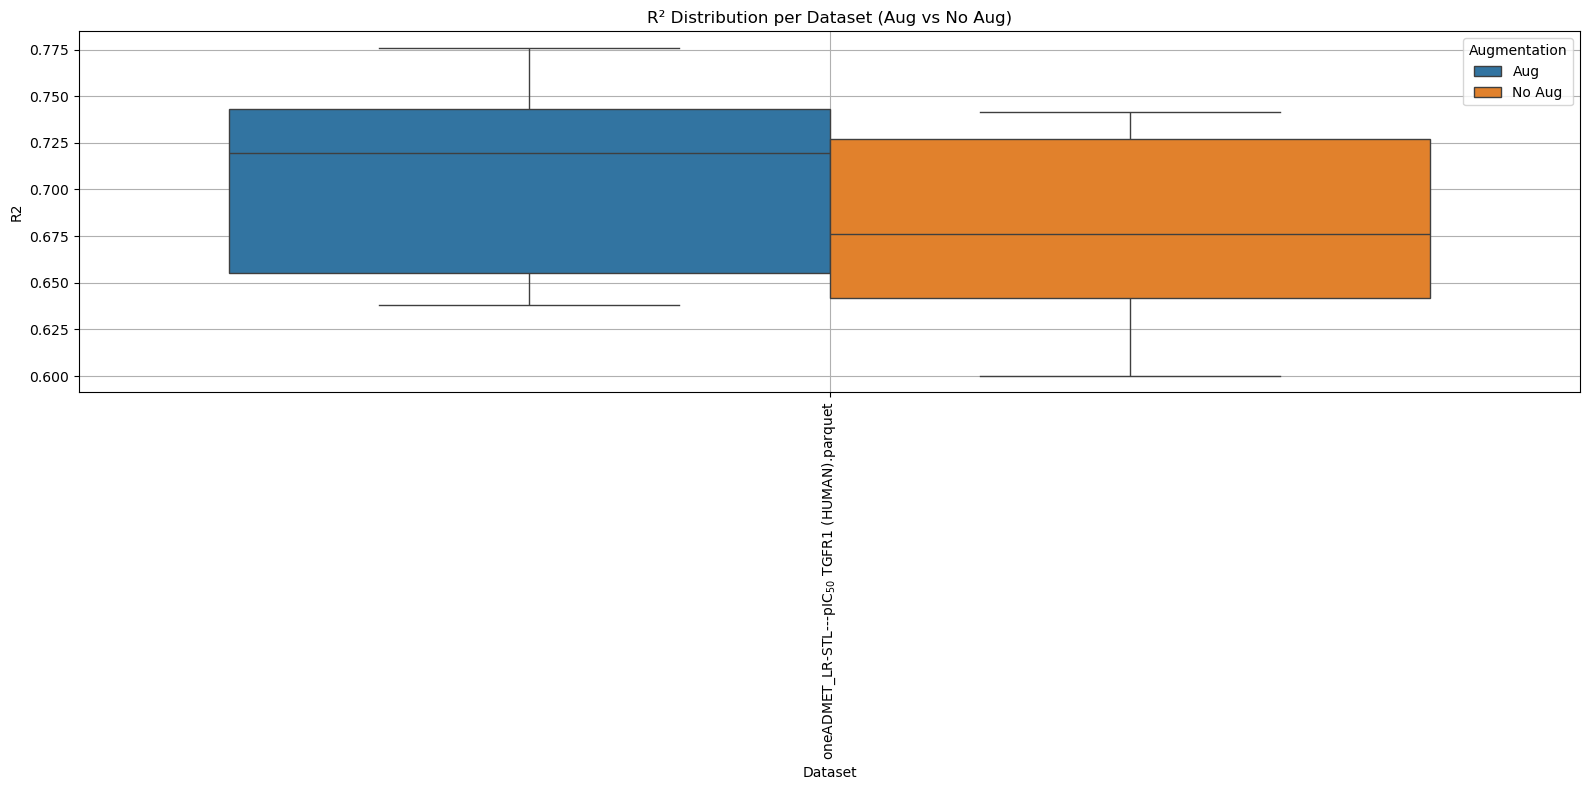

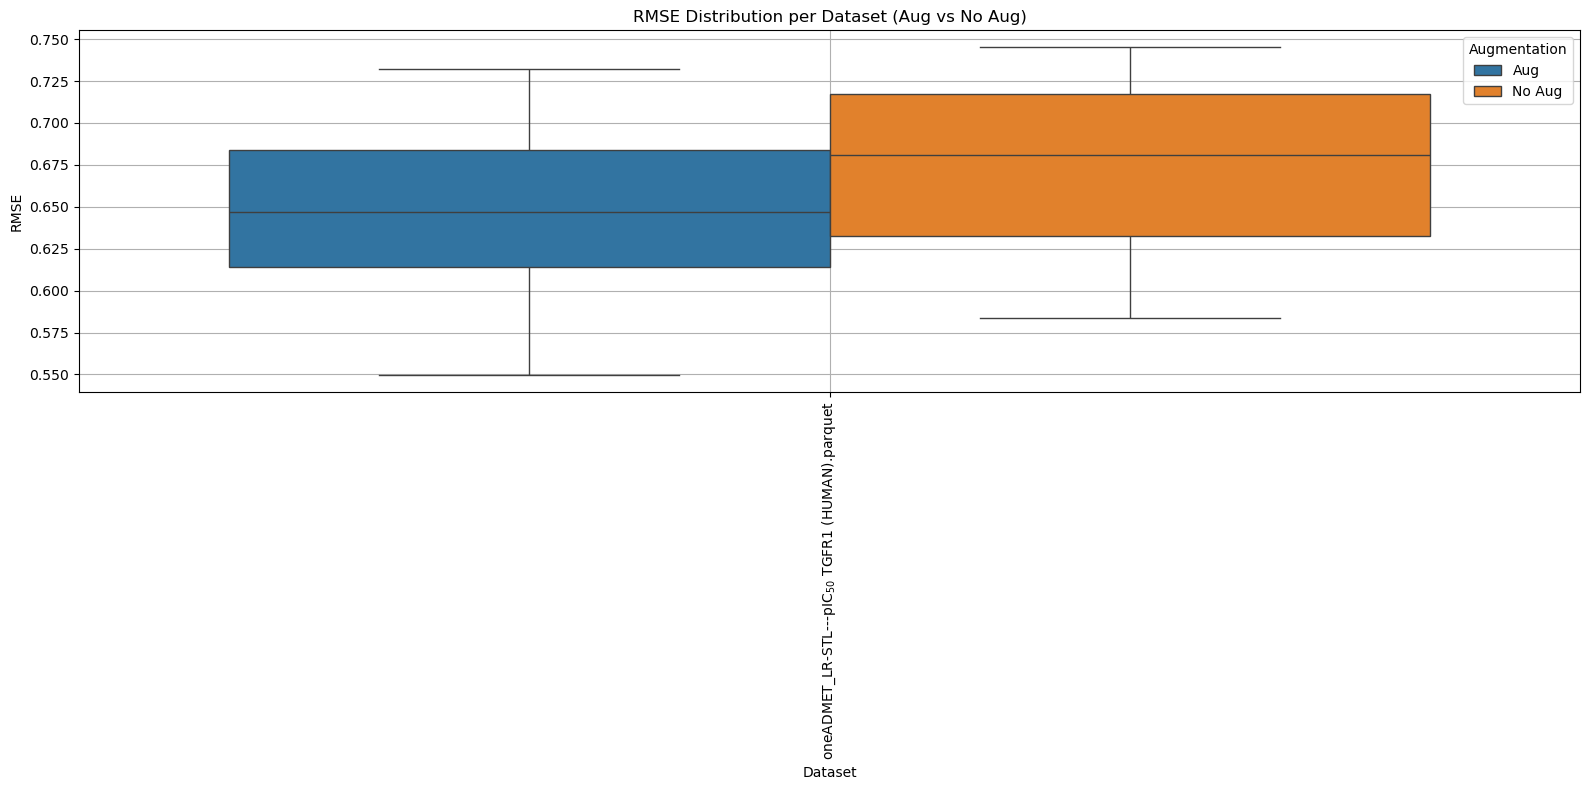

In [35]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def collect_perf_stats_all(base_dir_aug, base_dir_noaug, folds, reps=[1, 2, 3]):
    records = []

    # Collect all dataset filenames from one fold
    fold_dir = os.path.join(base_dir_aug, 'ABCDEFGHI', "STL", "RF_ECFP")
    all_files = [f for f in os.listdir(fold_dir) if f.endswith(".parquet")]

    print(fold_dir)

    for dataset_name in all_files:
        print(dataset_name)
        for aug_type, base_dir in zip(["Aug", "No Aug"], [base_dir_aug, base_dir_noaug]):
            for d in folds:
                file_path = os.path.join(base_dir, d, "STL", "RF_ECFP", dataset_name)
                if not os.path.exists(file_path):
                    continue
                try:
                    df = pd.read_parquet(file_path)
                    for k in reps:
                        y_true = df["Y"].tolist()
                        y_pred = df[f"pY_rep{k}"].tolist()
                        rmse = mean_squared_error(y_true, y_pred, squared=False)
                        r2 = r2_score(y_true, y_pred)
                        records.append({
                            "Dataset": dataset_name,
                            "Fold": d,
                            "Augmentation": aug_type,
                            "RMSE": rmse,
                            "R2": r2,
                            "Rep": k
                        })
                except:
                    continue

    df_perf = pd.DataFrame(records)

    # R² plot
    plt.figure(figsize=(16, 8))
    sns.boxplot(x="Dataset", y="R2", hue="Augmentation", data=df_perf)
    plt.title("R² Distribution per Dataset (Aug vs No Aug)")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # RMSE plot
    plt.figure(figsize=(16, 8))
    sns.boxplot(x="Dataset", y="RMSE", hue="Augmentation", data=df_perf)
    plt.title("RMSE Distribution per Dataset (Aug vs No Aug)")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_perf

# Example usage
df_stats_all = collect_perf_stats_all(
    base_dir_aug="../data/prediction/aug",
    base_dir_noaug="../data/prediction/noaug",
    folds=["BCDEFGHIJ", "ACDEFGHIJ", "ABDEFGHIJ", "ABCEFGHIJ","ABCDFGHIJ", "ABCDEGHIJ", "ABCDEFHIJ", "ABCDEFGIJ", "ABCDEFGHJ","ABCDEFGHI"]
)

In [ ]:
# So increasing the number of folds, increase the performance, so 10 fold is good for now I think